# Retrieve TESS Data Validation Products with Astroquery

In addition to producing light curves and target pixel files, TESS (Transiting Exoplanet Survey Satelite) searches the 2-minute light curve data for transiting exoplanets. The mission does the search on individual sectors. But it also does multi-sector searches where they stitch the time series from a range of sectors and then do a search.  For every star in a particular search that produces a significant transiting event, a set of Data Validation products are created. The set of products are:

- DV reports (pdf), one per star
- DV summaries (pdf), one per transit signal found
- DV mini-reports (pdf), one per star
- DV time series files (fits),  one per star, one extension per transit signal

In this tutorial we show how to use astroquery to request all of the DV files available for a star of interest (L98-59 in this case). We then open the DV time series file to plot the detrended light curves produced by the mission and also a folded light curve for each signal found by the mission.

Skills explored in this notebook:

- Retrieving TESS timeseries observations with astroquery
- Retrieving TESS Data Validation products with astroquery
- Reading in a DV FITS file with astropy.io.fits
- Plotting with Matplotlib

For more information about the DV time series files, see the notebook called "beginner_how_to_use_dvt". 

For more information about TESS data products, go to the [TESS Archive Manual](https://outerspace.stsci.edu/display/TESS)


---

## Import Statements

In [1]:
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy import table
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

## Use Astroquery to find Observations of L98-59
We begin by doing a cone search usig the `Observations.query_object` function and then filtering for time series observations made by TESS. This leaves us with just the TESS 2-minute cadence data observations. There are also many Sectors' worth of observations for this target, so to minimize how many we use for this tutorial, we will
only keep results from the first 13 Sectors.  For TESS observations, the Sector number is stored in the column
called `sequence_number`.

In [2]:
star_name = "L98-59"

# This query returns all obserations across all missions centered on our target.
observations = Observations.query_object(star_name, radius = "0 deg")
# Create a filter that will only pick out the observations we want: TESS timeseries missions from Sectors 13 and
# below.
obs_wanted = ((observations['dataproduct_type'] == 'timeseries') &
              (observations['obs_collection'] == 'TESS') &
             (observations['sequence_number'] <= 13))
# Print out a few columns to show what we have selected. Note that TESS multi-Sector observations are assigned
# a sequence_number based on the last Sector used in the range.
print(observations[obs_wanted]['obs_collection', 'project', 'obs_id', 'sequence_number'])

obs_collection project ... sequence_number
-------------- ------- ... ---------------
          TESS    TESS ...               6
          TESS    TESS ...               9
          TESS    TESS ...              13
          TESS    TESS ...               2
          TESS    TESS ...               5
          TESS    TESS ...               8
          TESS    TESS ...               9
          TESS    TESS ...              10
          TESS    TESS ...              11
          TESS    TESS ...              12


## Use Astroquery to Dowload DV Products
Use `Observations.get_product_list` to get a list of data products associated with the observations of interest. Each individual observation is associated with several data products, only some of which are the DV products we are interested in. In this case we want those data products that have "productSubGroupDescription" set to either DVT, DVM, DVS or DVR.  

Next, we use `Observations.download_products` to download our selected data files. This function returns a manifest, a table that contains the local path to the files that are downloaded.

**Note:** If you keep all results, this will download 115 files, which are roughly 1 GB. This is slightly excessive for a Notebook, so we're artificially selecting a set of ten files that contain our file of interest. You should not do this in your own search.

In [3]:
data_products = Observations.get_product_list(observations[obs_wanted])
products_wanted = Observations.filter_products(data_products, 
                                    productSubGroupDescription=["DVT","DVM","DVS","DVR"])

# Keep ten results from the list for smaller download size
products_wanted.sort('obsID')
products_wanted = products_wanted[-10:]


print(products_wanted["productFilename"])
manifest = Observations.download_products(products_wanted)

                        productFilename                        
---------------------------------------------------------------
   tess2019141104532-s0012-s0012-0000000307210830-00219_dvr.xml
   tess2019141104532-s0012-s0012-0000000307210830-00219_dvr.pdf
tess2019141104532-s0012-s0012-0000000307210830-01-00219_dvs.pdf
tess2018206190142-s0001-s0013-0000000307210830-03-00226_dvs.pdf
   tess2018206190142-s0001-s0013-0000000307210830-00226_dvr.pdf
   tess2018206190142-s0001-s0013-0000000307210830-00226_dvr.xml
   tess2018206190142-s0001-s0013-0000000307210830-00226_dvm.pdf
tess2018206190142-s0001-s0013-0000000307210830-01-00226_dvs.pdf
tess2018206190142-s0001-s0013-0000000307210830-02-00226_dvs.pdf
  tess2018206190142-s0001-s0013-0000000307210830-00226_dvt.fits
INFO: Found cached file ./mastDownload/TESS/tess2019140104343-s0012-0000000307210830-0144-s/tess2019141104532-s0012-s0012-0000000307210830-00219_dvr.xml with expected size 361869. [astroquery.query]


INFO: Found cached file ./mastDownload/TESS/tess2019140104343-s0012-0000000307210830-0144-s/tess2019141104532-s0012-s0012-0000000307210830-00219_dvr.pdf with expected size 36277550. [astroquery.query]


INFO: Found cached file ./mastDownload/TESS/tess2019140104343-s0012-0000000307210830-0144-s/tess2019141104532-s0012-s0012-0000000307210830-01-00219_dvs.pdf with expected size 738382. [astroquery.query]


INFO: Found cached file ./mastDownload/TESS/tess2018206190142-s0001-s0013-0000000307210830/tess2018206190142-s0001-s0013-0000000307210830-03-00226_dvs.pdf with expected size 3506768. [astroquery.query]


INFO: Found cached file ./mastDownload/TESS/tess2018206190142-s0001-s0013-0000000307210830/tess2018206190142-s0001-s0013-0000000307210830-00226_dvr.pdf with expected size 68942060. [astroquery.query]


INFO: Found cached file ./mastDownload/TESS/tess2018206190142-s0001-s0013-0000000307210830/tess2018206190142-s0001-s0013-0000000307210830-00226_dvr.xml with expected size 1595489. [astroquery.query]


INFO: Found cached file ./mastDownload/TESS/tess2018206190142-s0001-s0013-0000000307210830/tess2018206190142-s0001-s0013-0000000307210830-00226_dvm.pdf with expected size 34180506. [astroquery.query]


INFO: Found cached file ./mastDownload/TESS/tess2018206190142-s0001-s0013-0000000307210830/tess2018206190142-s0001-s0013-0000000307210830-01-00226_dvs.pdf with expected size 3451461. [astroquery.query]


INFO: Found cached file ./mastDownload/TESS/tess2018206190142-s0001-s0013-0000000307210830/tess2018206190142-s0001-s0013-0000000307210830-02-00226_dvs.pdf with expected size 2890345. [astroquery.query]


INFO: Found cached file ./mastDownload/TESS/tess2018206190142-s0001-s0013-0000000307210830/tess2018206190142-s0001-s0013-0000000307210830-00226_dvt.fits with expected size 68114880. [astroquery.query]


In [4]:
products_wanted['size']/10**6

0.361869
36.27755
0.738382
3.506768
68.94206
1.595489
34.180506
3.451461
2.890345
68.11488


## Download Complete
You have now downloaded a subset of the TESS DV products for this star and their locations can be seen by printing the "Local Path" in the manifest. Notice that because this star was observed in many sectors, there are many different sets of DV products, one set for each range of sectors searched.

In [5]:
print( manifest['Local Path'] )

                                                             Local Path                                                            
-----------------------------------------------------------------------------------------------------------------------------------
   ./mastDownload/TESS/tess2019140104343-s0012-0000000307210830-0144-s/tess2019141104532-s0012-s0012-0000000307210830-00219_dvr.xml
   ./mastDownload/TESS/tess2019140104343-s0012-0000000307210830-0144-s/tess2019141104532-s0012-s0012-0000000307210830-00219_dvr.pdf
./mastDownload/TESS/tess2019140104343-s0012-0000000307210830-0144-s/tess2019141104532-s0012-s0012-0000000307210830-01-00219_dvs.pdf
 ./mastDownload/TESS/tess2018206190142-s0001-s0013-0000000307210830/tess2018206190142-s0001-s0013-0000000307210830-03-00226_dvs.pdf
    ./mastDownload/TESS/tess2018206190142-s0001-s0013-0000000307210830/tess2018206190142-s0001-s0013-0000000307210830-00226_dvr.pdf
    ./mastDownload/TESS/tess2018206190142-s0001-s0013-0000000307210830/tess2

## Examine the Download Manifest

TESS file names tell you a lot about what is in the file. In the function `parse_manifest` below I break them apart so that I can make an easy to read table about the type of data that we downloaded.  Then we write-out that part of the table.   This makes it obvious that there are lots of different sets of DV files based on different searches, each with a different sector range.  For each sector it was observed, there is a single sector search, and then there are also several multi sector searches.

In [6]:
def parse_manifest(manifest):
    """
    Parse manifest and add back columns that are useful for TESS DV exploration.
    """
    results = deepcopy(manifest)
    filenames = []
    sector_range = []
    exts = []
    for i,f in enumerate(manifest['Local Path']):
        file_parts = np.array(np.unique(f.split(sep = '-')))
        sectors = list( map ( lambda x: x[0:2] == 's0', file_parts))
        s1 = file_parts[sectors][0]
        try:
            s2 = file_parts[sectors][1]
        except:
            s2 = s1
        sector_range.append("%s-%s" % (s1,s2))
        path_parts = np.array(f.split(sep = '/'))
        filenames.append(path_parts[-1])
        exts.append(path_parts[-1][-8:])

    results.add_column(table.Column(name = "filename", data = filenames))
    results.add_column(table.Column(name = "sectors", data = sector_range))
    results.add_column(table.Column(name = "fileType", data = exts))
    results.add_column(table.Column(name = "index", data = np.arange(0,len(manifest))))
    
    return results

#Run parser and print
results = parse_manifest(manifest)
print(results['index','sectors','fileType'])

index   sectors   fileType
----- ----------- --------
    0 s0012-s0012 _dvr.xml
    1 s0012-s0012 _dvr.pdf
    2 s0012-s0012 _dvs.pdf
    3 s0001-s0013 _dvs.pdf
    4 s0001-s0013 _dvr.pdf
    5 s0001-s0013 _dvr.xml
    6 s0001-s0013 _dvm.pdf
    7 s0001-s0013 _dvs.pdf
    8 s0001-s0013 _dvs.pdf
    9 s0001-s0013 dvt.fits


## Plot the DVT File
The time series data used to find the repeating transit signals (which are also known as Threshold Crossing events (TCEs)) is found in the dvt.fits files.  As you can see there is a dvt file. If we want the file with the most data, we should pick the one with the longest sector range in the file name.  In this case it is s0001-s0013. 

In [7]:
print(results['index', 'sectors', 'fileType'][results['sectors'] == "s0001-s0013"])

index   sectors   fileType
----- ----------- --------
    3 s0001-s0013 _dvs.pdf
    4 s0001-s0013 _dvr.pdf
    5 s0001-s0013 _dvr.xml
    6 s0001-s0013 _dvm.pdf
    7 s0001-s0013 _dvs.pdf
    8 s0001-s0013 _dvs.pdf
    9 s0001-s0013 dvt.fits


### Plot the DV Median-Detrended Time Series
The median detrended fluxes are stored in the first extension under 'LC_DETREND'. This is a median detrended version of the light curve that was searched for transit signals. While in the continuous viewing zone, L98-59 was not observed during every sector so there will be gaps in our light curve.

In [8]:
# Locate the file that has the data
want = (results['sectors'] == "s0001-s0013") & (results['fileType'] == "dvt.fits")
dvt_filename = manifest[want]['Local Path'][0]

# Print out the file info
fits.info(dvt_filename)

Filename: ./mastDownload/TESS/tess2018206190142-s0001-s0013-0000000307210830/tess2018206190142-s0001-s0013-0000000307210830-00226_dvt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   ()      
  1  TCE_1         1 BinTableHDU     92   236344R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  TCE_2         1 BinTableHDU     92   236344R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  3  TCE_3         1 BinTableHDU     92   236344R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  4  Statistics    1 BinTableHDU    157   236344R x 38C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


Text(0.5, 1.0, 'Data Validation Detrended Light Curve for L98-59')

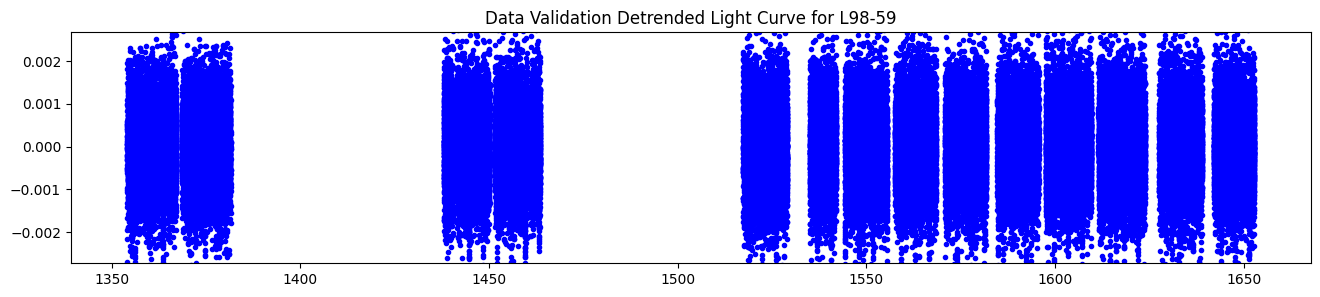

In [9]:
# Plot the detrended photometric time series in the first binary table. 
data = fits.getdata(dvt_filename, 1)
time = data['TIME']
relflux = data['LC_DETREND']

plt.figure(figsize = (16,3))
plt.plot (time, relflux, 'b.')
plt.ylim(1.2* np.nanpercentile(relflux, .5) , 1.2 * np.nanpercentile(relflux, 99.5))
plt.title('Data Validation Detrended Light Curve for %s' % (star_name))

### Plot Folded Light Curve
Each extension of the DVT data file contains a separate TCE. After the pipeline finds a set of transits, the transits are removed and the light curve is once again searched for transits.  L98-59 has three TCEs, each is consistent with the three confirmed planets found around this star.  Here we plot the phase folded light curve for each TCE, each as its own subplot.  The DVT file also contains a transit model as one of the columns in the FITS table. We overplot that in orange.

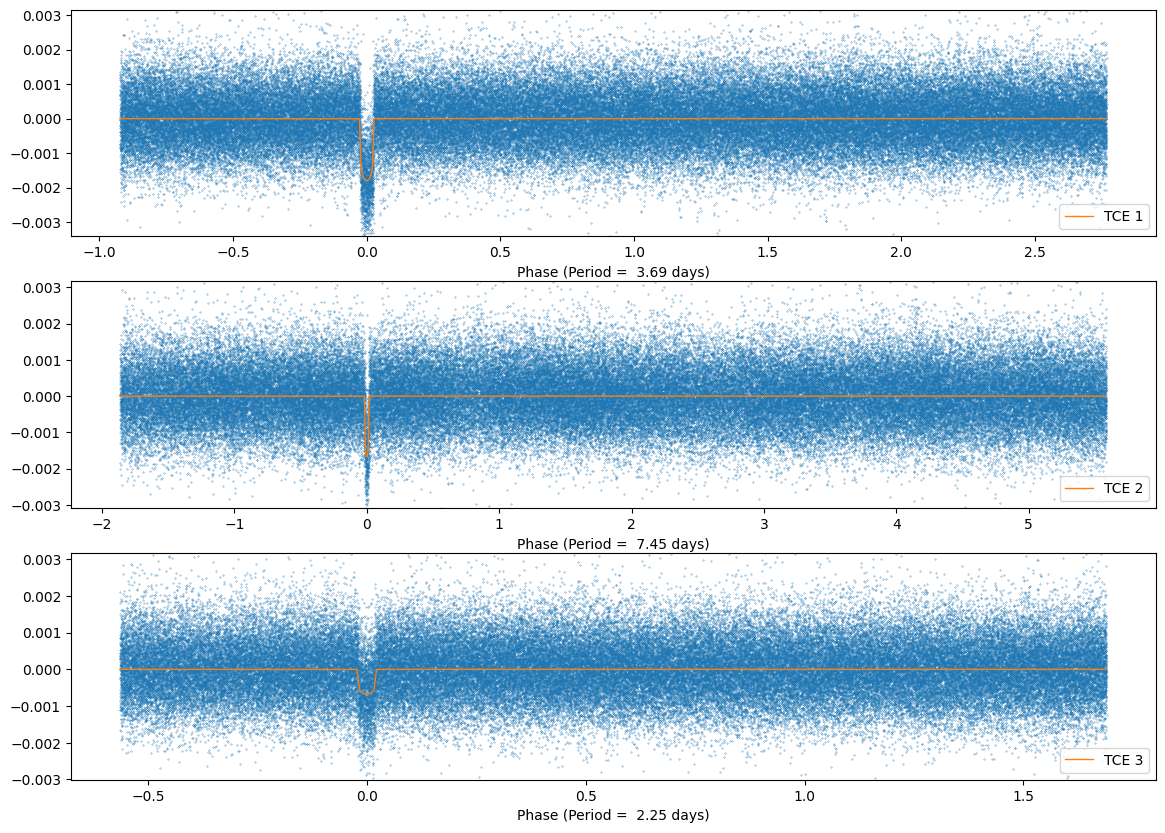

In [10]:
def plot_folded(phase, data, model, ext, period):
    isort = phase.argsort()
    
    plt.plot(phase[isort], data[isort], '.', ms = .5)
    plt.plot(phase[isort], model[isort], '-', lw = 1, label = "TCE %i" % ext)
    plt.xlabel('Phase (Period = %5.2f days)' % period)
    plt.ylim(1.5 * np.nanpercentile(data, .5) , 1.4 * np.nanpercentile(data,99.5))
    plt.legend(loc = "lower right")

plt.figure(figsize = (14,10))

nTCEs = fits.getheader(dvt_filename)['NEXTEND'] - 2

for ext in range(1, nTCEs + 1):
    data = fits.getdata(dvt_filename, ext)
    head = fits.getheader(dvt_filename, ext)
    period = head['TPERIOD']
    phase = data['PHASE']
    flux = data['LC_INIT']
    model = data['MODEL_INIT']
    plt.subplot(3, 1, ext)
    plot_folded(phase, flux, model, ext, period)

<a id="about_ID"></a>
## About this Notebook
**Authors:** Susan E. Mullally, STScI 
<br>**Last updated**: Aug 2023

[Top of Page](#title_ID)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="STScI logo" width="200px"/> 